In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils import data
import torchvision
from torchvision import transforms
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt
%matplotlib inline
from d2l import torch as d2l
import random
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
import time
import pandas as pd
from PIL import Image

In [2]:
path = '../data/dog-breed-identification/'

In [3]:
train_csv = pd.read_csv(path + 'labels.csv')
train_csv

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever
...,...,...
10217,ffd25009d635cfd16e793503ac5edef0,borzoi
10218,ffd3f636f7f379c51ba3648a9ff8254f,dandie_dinmont
10219,ffe2ca6c940cddfee68fa3cc6c63213f,airedale
10220,ffe5f6d8e2bff356e9482a80a6e29aac,miniature_pinscher


In [4]:
print(train_csv.shape)

(10222, 2)


In [5]:
train_csv['id'][0]

'000bec180eb18c7604dcecc8fe0dba07'

In [6]:
label_list = sorted(train_csv['breed'].unique().tolist())
label_list[:10]

['affenpinscher',
 'afghan_hound',
 'african_hunting_dog',
 'airedale',
 'american_staffordshire_terrier',
 'appenzeller',
 'australian_terrier',
 'basenji',
 'basset',
 'beagle']

In [7]:
test_csv = pd.read_csv(path + 'sample_submission.csv')

In [8]:
print(test_csv.shape)

(10357, 121)


In [9]:
# images = []
# for i in range(len(train_csv['id'])):
#     image = (transforms.ToTensor()(Image.open(path + 'train/' + train_csv['id'][i] + '.jpg'))).to(torch.float32).flatten(1, 2)
#     images.append(image)
# flattened_image = torch.cat(images, dim=1)
# print(flattened_image.shape)                                    # torch.Size([3, 1882650608])
# print(flattened_image.mean(dim=1), flattened_image.std(dim=1))  # tensor([0.4736, 0.4504, 0.3909]) tensor([0.2655, 0.2607, 0.2650])

In [10]:
class TrainDataset(data.Dataset):
    def __init__(self):
        super().__init__()
        self.interpolation_modes = [transforms.InterpolationMode.NEAREST,
                                    transforms.InterpolationMode.BILINEAR,
                                    transforms.InterpolationMode.BICUBIC]
        self.trans = transforms.Compose([transforms.RandomHorizontalFlip(p=0.5),
                                         transforms.ColorJitter(brightness=0.2,
                                                                contrast=0.2,
                                                                saturation=0.2,
                                                                hue=0.2),
                                         transforms.ToTensor(),
                                         transforms.Normalize(mean=[0.4736, 0.4504, 0.3909],
                                                              std=[0.2655, 0.2607, 0.2650],
                                                              inplace=True)])
        
    def __len__(self):
        return train_csv.shape[0]
    
    def __getitem__(self, index):
        image = Image.open(path + 'train/' + train_csv['id'][index] + '.jpg')
        label = label_list.index(train_csv['breed'][index])
        resized_crop = transforms.RandomResizedCrop(size=224,
                                                    scale=(0.08, 1.0),
                                                    ratio=(0.75, 1.3333333333333333),
                                                    interpolation=self.interpolation_modes[random.randint(0, 2)])
        return self.trans(resized_crop(image)), label

In [11]:
class TestDataset(data.Dataset):
    def __init__(self):
        super().__init__()
        self.trans = transforms.Compose([transforms.Lambda(self.get_144_samples),
                                         transforms.Lambda(lambda crops: \
                                                           torch.stack([transforms.ToTensor()(crop) for crop in crops])),
                                         transforms.Normalize(mean=[0.4736, 0.4504, 0.3909],
                                                              std=[0.2655, 0.2607, 0.2650],
                                                              inplace=True)])
    def get_144_samples(self, image):
        samples = []
        self.sizes = [256, 288, 320, 352]
        for size in self.sizes:
            resized_image = transforms.Resize(size)(image)
            crops = self.get_3_crops(resized_image)
            for crop in crops:
                samples.append(transforms.Resize(224)(crop))
                samples.append(transforms.RandomHorizontalFlip(1)(samples[-1]))
                samples += transforms.TenCrop(224)(crop)
        assert(len(samples) == 144)
        return samples
            
    def get_3_crops(self, image):
        images = []
        x, y = image.size
        if x > y:
            boxes = [[0, 0, y, y], [(x-y)//2, 0, (x+y)//2, y], [(x-y), 0, x, y]]
        elif x < y:
            boxes = [[0, 0, x, x], [0, (y-x)//2, x, (y+x)//2], [0, (y-x), x, y]]
        elif x == y:
            boxes = [[0, 0, x, y], [0, 0, x, y],  [0, 0, x, y]]
        for box in boxes:
            images.append(image.crop(box))
        return images
    
    def __len__(self):
        return test_csv.shape[0]
    
    def __getitem__(self, index):
        image = Image.open(path + 'test/' + test_csv['id'][index] + '.jpg')
        return self.trans(image)

(351, 500)


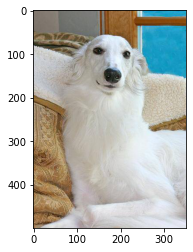

In [12]:
test_image1 = Image.open(path + 'train/' + train_csv['id'][1481] + '.jpg')
print(test_image1.size)
plt.imshow(test_image1)

(500, 375)


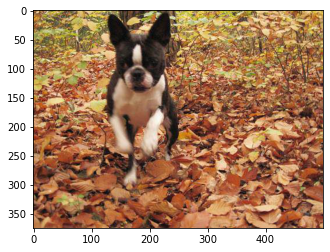

In [13]:
test_image2 = Image.open(path + 'train/' + train_csv['id'][0] + '.jpg')
print(test_image2.size)
plt.imshow(test_image2)

In [14]:
class CBR(nn.Module):
    def __init__(self,
                 in_channels,
                 out_channels,
                 kernel_size=1,
                 padding='same',
                 stride=1,
                 batch_norm=False):
        super().__init__()
        self.batch_norm = batch_norm
        self.conv = nn.Conv2d(in_channels, out_channels,
                              kernel_size=kernel_size, padding=padding,
                              stride=stride, bias=not self.batch_norm)
        if self.batch_norm:
            self.bn = nn.BatchNorm2d(out_channels)
        self.ReLU = nn.ReLU(inplace=True)
    
    def forward(self, x):
        output = self.conv(x)
        if self.batch_norm:
            output = self.bn(output)
        output = self.ReLU(output)
        return output

In [15]:
class InceptionBlock(nn.Module):
    def __init__(self,
                 in_channels:int,
                 branch_1x1:int,
                 branch_3x3:list,
                 branch_5x5:list,
                 branch_pool:int,
                 batch_norm:bool):
        super().__init__()
        self.branch_1x1 = CBR(in_channels, branch_1x1, batch_norm=batch_norm)
        self.branch_3x3 = nn.Sequential(*[CBR(in_channels, branch_3x3[0], batch_norm=batch_norm),
                                         CBR(branch_3x3[0], branch_3x3[1], kernel_size=3, batch_norm=batch_norm)])
        self.branch_5x5 = nn.Sequential(*[CBR(in_channels, branch_5x5[0], batch_norm=batch_norm),
                                         CBR(branch_5x5[0], branch_5x5[1], kernel_size=5, batch_norm=batch_norm)])
        self.branch_pool = nn.Sequential(*[nn.MaxPool2d(kernel_size=3, padding=1, stride=1),
                                          CBR(in_channels, branch_pool, batch_norm=batch_norm)])
    def forward(self, x):
        output_1x1 = self.branch_1x1(x)
        output_3x3 = self.branch_3x3(x)
        output_5x5 = self.branch_5x5(x)
        output_pool = self.branch_pool(x)
        output = torch.cat((output_1x1, output_3x3, output_5x5, output_pool), dim=1)
        assert(output.shape[-2:] == x.shape[-2:])
        return output

In [16]:
class GoogLeNet(nn.Module):
    def __init__(self, batch_norm=False, dropout=0.4):
        super().__init__()
        self.batch_norm = batch_norm
        self.stage_1 = nn.Sequential(*[CBR(3, 64, kernel_size=7, stride=2, padding=3, batch_norm=batch_norm),
                                       nn.MaxPool2d(kernel_size=3, stride=2, padding=1)])
        self.stage_2 = nn.Sequential(*[CBR(64, 192, kernel_size=3, batch_norm=batch_norm),
                                       nn.MaxPool2d(kernel_size=3, stride=2, padding=1)])
        self.stage_3 = nn.Sequential(*[InceptionBlock(192, 64,  [96,  128], [16, 32],  32,  batch_norm),
                                       InceptionBlock(256, 128, [128, 192], [32, 96],  64,  batch_norm),
                                       nn.MaxPool2d(kernel_size=3, stride=2, padding=1)])
        self.stage_4 = nn.Sequential(*[InceptionBlock(480, 192, [96,  208], [16, 48],  64,  batch_norm),
                                       InceptionBlock(512, 160, [112, 224], [24, 64],  64,  batch_norm),
                                       InceptionBlock(512, 128, [128, 256], [24, 64],  64,  batch_norm),
                                       InceptionBlock(512, 112, [144, 288], [32, 64],  64,  batch_norm),
                                       InceptionBlock(528, 256, [160, 320], [32, 128], 128, batch_norm),
                                       nn.MaxPool2d(kernel_size=3, stride=2, padding=1)])
        self.stage_5 = nn.Sequential(*[InceptionBlock(832, 256, [160, 320], [32, 128], 128, batch_norm),
                                       InceptionBlock(832, 384, [192, 384], [48, 128], 128, batch_norm),
                                       nn.AdaptiveAvgPool2d((1, 1))])
        self.FC = nn.Sequential(*[nn.Flatten(),
                                  nn.Dropout(p=dropout),
                                  nn.Linear(1024, 1000)])
    
    def forward(self, x):
        for i in range(1, 6):
            x = getattr(self, 'stage_' + str(i))(x)
        x = self.FC(x)
        return x

In [17]:
googlenet = GoogLeNet(batch_norm=True, dropout=0.4).to(device)
googlenet

GoogLeNet(
  (stage_1): Sequential(
    (0): CBR(
      (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (ReLU): ReLU(inplace=True)
    )
    (1): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (stage_2): Sequential(
    (0): CBR(
      (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=same, bias=False)
      (bn): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (ReLU): ReLU(inplace=True)
    )
    (1): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (stage_3): Sequential(
    (0): InceptionBlock(
      (branch_1x1): CBR(
        (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), padding=same, bias=False)
        (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (ReLU): ReLU(inplace

In [18]:
test_input = torch.zeros(144, 3, 224, 224, device=device)
print(googlenet(test_input).shape)

torch.Size([144, 1000])
